In [1]:
# Setup environment - more here than needed, need to clean up
import os
import glob
import subprocess
import sys
import time
import io
import pandas as pd
from scipy.io import netcdf as nc
from cf_units import Unit

import matplotlib.pyplot as plt
from os.path import expanduser

# Define output path
home = expanduser("~")
output_dir = os.path.join(home,'scratch')  # main output directory.
os.makedirs(os.path.dirname(output_dir), exist_ok=True)
print(output_dir)

/Users/shawnserbin/scratch


In [10]:
# Grab latest CTSM docker container from Docker hub
source = "serbinsh/ctsm_containers"
docker_container_tag = "ctsm-release-clm5.0.15"
container_name = ''.join([source,":",docker_container_tag])
print(container_name)
docker_pull_command = ''.join(["docker pull ",source,":",docker_container_tag])
os.system(docker_pull_command)

# you should see docker pull progress in the Jupyter shell

serbinsh/ctsm_containers:ctsm-release-clm5.0.15


0

In [11]:
# Define run parameters for CTSM
start_year = '1900-01-01'  # you need to place this in the single quotations
num_run_years = 120
hostname = "modex"
user = "clmuser"

# Define input/output paths (host:container)
cesm_input_data_paths = ''.join([home,"/Data/cesm_input_data:/data"])
output_path = ''.join([output_dir,":/ctsm_output"])
print(output_path)

# Define script to run
host_script_dir = ''.join([home,"/Data/ctsm_fates_scripts/ctsm_scripts:/ctsm_run_scripts"])
ctsm_case_build_script = "/ctsm_run_scripts/create_case_1pt_example_USNR1_all_outputs.sh"
print(host_script_dir)

/Users/shawnserbin/scratch:/ctsm_output
/Users/shawnserbin/Data/ctsm_fates_scripts/ctsm_scripts:/ctsm_run_scripts


In [12]:
# Define case build command
run_command = ''.join(["docker run --hostname=",hostname," --user ",user," -v ", host_script_dir," -v ", cesm_input_data_paths, " -v ", output_path, " ", container_name, " ", ctsm_case_build_script, " ", "'",start_year.__str__(),"'", " ", num_run_years.__str__()," > ",output_dir,"/build.log 2>&1"])
print(run_command)


docker run --hostname=modex --user clmuser -v /Users/shawnserbin/Data/ctsm_fates_scripts/ctsm_scripts:/ctsm_run_scripts -v /Users/shawnserbin/Data/cesm_input_data:/data -v /Users/shawnserbin/scratch:/ctsm_output serbinsh/ctsm_containers:ctsm-release-clm5.0.15 /ctsm_run_scripts/create_case_1pt_example_USNR1_all_outputs.sh '1900-01-01' 120 > /Users/shawnserbin/scratch/build.log 2>&1


In [14]:
# Create new case - output build log to file to later parse for case_dir
start = time.time()
os.system(run_command)
# get runtime
end = time.time()
#Print runtime
print(end - start)

158.10919785499573


In [15]:
# find case dir - probably should be using subprocess instead of os.system - then we 
# can capture standard out
#
# could be brittle, assumes the internal output dir is /ctsm_output/
parse_command = ''.join(["awk '/ctsm_output/{print $NF}'"," ",output_dir,"/build.log | head -n1 > ",output_dir,"/case_dir.txt 2>&1"])
out = os.system(parse_command)
with open(''.join([output_dir,"/case_dir.txt"]), 'rt') as f:
     case_directory = f.readline().replace('\n', '')
print(case_directory)
remove = ''.join(["rm ",output_dir,"/build.log && ","rm ",output_dir,"/case_dir.txt"])
out = os.system(remove)
#

/ctsm_output/CLM5_1554580594


In [16]:
# Run case
run_command = ''.join(["docker run --hostname=",hostname," --user ",user," -v ", cesm_input_data_paths, " -v ", output_path, " ",container_name, " ","/bin/sh -c 'cd ",case_directory," && ./case.submit'"])
print(run_command)


docker run --hostname=modex --user clmuser -v /Users/shawnserbin/Data/cesm_input_data:/data -v /Users/shawnserbin/scratch:/ctsm_output serbinsh/ctsm_containers:ctsm-release-clm5.0.15 /bin/sh -c 'cd /ctsm_output/CLM5_1554580594 && ./case.submit'


In [17]:
# Run
start = time.time()
# run the docker container
os.system(run_command)
# get runtime
end = time.time()
#Print runtime
print(end - start)

13391.311339855194


In [26]:
# explore output
host_case_dir = os.path.basename(case_directory)

# first concatenate netCDF files
ncfiles = ''.join([host_case_dir,".clm2.h0.*"])
print(ncfiles)

concat_command = ''.join(["cd ",output_dir,"/",host_case_dir,"/run"," && ncrcat ",ncfiles," all_years.nc"])
print(concat_command)
os.system(concat_command)

CLM5_1554580594.clm2.h0.*
cd /Users/shawnserbin/scratch/CLM5_1554580594/run && ncrcat CLM5_1554580594.clm2.h0.* all_years.nc


0

In [28]:
# view output header
ncdump = ''.join(["cd ",output_dir,"/",host_case_dir,"/run"," && ncdump -h all_years.nc"])
print(ncdump)
os.system(ncdump)

cd /Users/shawnserbin/scratch/CLM5_1554580594/run && ncdump -h all_years.nc


0

In [29]:
# get output
filename_in = ''.join([output_dir,"/",host_case_dir,"/run/all_years.nc"])
print(filename_in)
fin = nc.netcdf_file(filename_in)


/Users/shawnserbin/scratch/CLM5_1554580594/run/all_years.nc


In [30]:
## read the coordinate data for the various dimensions
time = fin.variables['time'][:]  ### time dimension, put in unit of years
print(time)

[0.0000000e+00 4.1666668e-02 8.3333336e-02 ... 4.3828918e+04 4.3828957e+04
 4.3829000e+04]


In [31]:
# get variables
gpp = fin.variables['GPP'][:]
print(gpp)
lai = fin.variables['TLAI'][:]
print(lai)
totvegc = fin.variables['TOTVEGC'][:]
print(totvegc)
tbot = fin.variables['TBOT'][:]

[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [4.5104434e-06]
 [3.9979982e-06]
 [3.0321453e-06]]
[[0.        ]
 [0.09171552]
 [0.18342568]
 ...
 [0.69640976]
 [0.69640356]
 [0.69639736]]
[[ 140.31258]
 [ 140.31145]
 [ 140.30992]
 ...
 [2811.5776 ]
 [2811.5662 ]
 [2811.555  ]]


Text(0, 0.5, 'GPP (gC/m2/hr)')

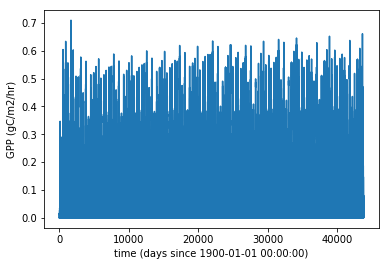

In [32]:
gpp2 = gpp*3600
# Plot output
plt.plot(time,gpp2, label='GPP')
plt.xlabel(''.join(['time (days since ',start_year,' 00:00:00)']))
plt.ylabel('GPP (gC/m2/hr)')

Text(0, 0.5, 'LAI (m2/m2)')

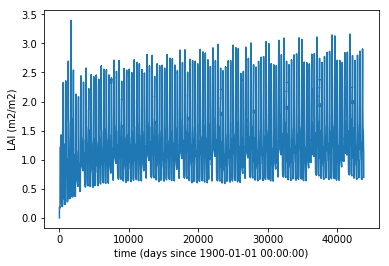

In [33]:
plt.plot(time,lai, label='TLAI')
plt.xlabel(''.join(['time (days since ',start_year,' 00:00:00)']))
plt.ylabel('LAI (m2/m2)')

Text(0.5, 0, 'time (days since 1900-01-01 00:00:00)')

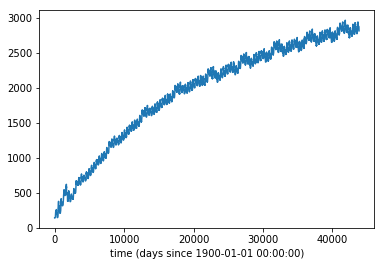

In [34]:
plt.plot(time,totvegc, label='TOTVEGC')
plt.xlabel(''.join(['time (days since ',start_year,' 00:00:00)']))

In [35]:
import netCDF4
import pandas as pd
import numpy as np
ncfile = netCDF4.Dataset(filename_in, 'r')
time = ncfile.variables['time'] # do not cast to numpy array yet 
time_convert = netCDF4.num2date(time[:], time.units, time.calendar)

lai_df = pd.DataFrame(data=lai,index=time_convert)
lai_means = lai_df.groupby(pd.Grouper(freq='1M')).mean()
print(lai_means.head(3))

totvegc_df = pd.DataFrame(data=totvegc,index=time_convert)
#df.groupby(df.index.floor('D')).mean()
totvegc_means = totvegc_df.groupby(pd.Grouper(freq='1M')).mean()
print(totvegc_means.head(3))


                   0
1900-01-31  0.180539
1900-02-28  0.176605
1900-03-31  0.173509
                     0
1900-01-31  140.336929
1900-02-28  140.673706
1900-03-31  143.846405


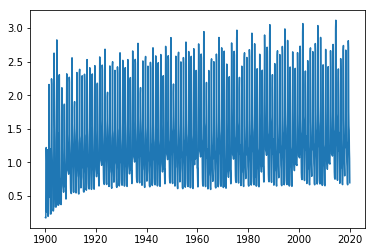

In [36]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.plot(lai_means, label='Monthly LAI')

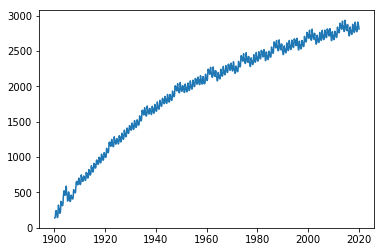

In [37]:
plt.plot(totvegc_means, label='Monthly TOTVEGC')